# Convert NN-MPO to ITensor MPO

![](assets/nnmpo2mpo.png)

- See also our [DVR(`discvar`) documentation](https://kenhino.github.io/Discvar/index.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from discvar import HarmonicOscillator as HO

import pompon
import pompon.utils

## Define harmonic frequencies

In [2]:
freqs = [1193.495, 1264.160, 1529.535, 1863.269, 2867.313, 2926.465]

## Load trained NN-MPO

![](assets/nnmpo.png)

In [3]:
nnmpo = pompon.NNMPO.import_h5("data/nnmpo_final_rmse_8.365e-04.h5")
nnmpo.rescale(1.0, 1 / 27.21138)  # eV to Eh

2024-10-18 16:14:49 - INFO:pompon.pompon.model - Model is imported from data/nnmpo_final_rmse_8.365e-04.h5


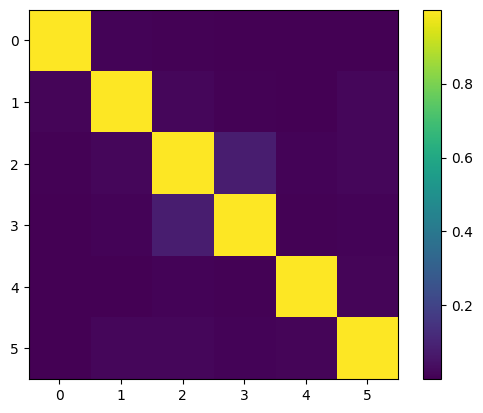

In [4]:
U = np.array(nnmpo.coordinator.U.data)
plt.imshow(np.abs(U))
plt.colorbar()
plt.show()

$$
Q = \xi U
$$
$$
\frac12 \xi 
\begin{pmatrix}
\omega_1 ^2 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & \omega_f^2
\end{pmatrix}
\xi^T
= \frac12 Q U^T 
\begin{pmatrix}
\omega_1 ^2 & \cdots & 0 \\
\vdots & \ddots & \vdots \\
0 & \cdots & \omega_f^2
\end{pmatrix}
U Q^T
$$

In [5]:
latent_freqs = np.sqrt(np.diag((U.T @ np.diag(np.array(freqs) ** 2) @ U)))
print(latent_freqs)

[1193.51968001 1265.06644987 1532.43704947 1861.63527484 2867.18137401
 2925.71361408]


## Define wavefunction basis 

![](assets/basis.png)

`basis` = $\left[|\sigma_1\rangle, |\sigma_2\rangle, \cdots, |\sigma_6\rangle\right]$

In [6]:
N = 9
basis = [HO(ngrid=N, omega=omega, units="cm-1") for omega in latent_freqs]

## Evaluate one-dimensional integral

![](assets/one-dim-integral.png)

`basis_ints`=$\left[\langle\sigma_1|\phi_{\rho_1}|\sigma_1\rangle, \langle\sigma_2|\phi_{\rho_2}|\sigma_2\rangle, \cdots, \langle\sigma_6|\phi_{\rho_6}|\sigma_6\rangle\right]$

Note that off-diagnal terms are approximated to 0 by DVR.

In [7]:
basis_ints = [
    getattr(nnmpo.basis, f"phi{i}").forward(
        np.array(basis[i].get_grids()), nnmpo.q0[:, i]
    )
    for i in range(6)
]
delta = np.eye(N, N)
basis_ints_full = [
    np.einsum("ij,ik->ijk", basis_ints[i], delta) for i in range(6)
]

## Conversion

![](assets/nnmpo2mpo.png)

In [8]:
mpo = nnmpo.convert_to_mpo(basis_ints_full)
for core in mpo:
    print(core.shape)

(1, 9, 9, 5)
(5, 9, 9, 14)
(14, 9, 9, 14)
(14, 9, 9, 14)
(14, 9, 9, 6)
(6, 9, 9, 1)


## Define Kinetic MPO

KEO-MPO can be encoded into 
$$
\begin{pmatrix}
\frac{-\hat{P}_1^2}{2} & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0 \\
\frac{-\hat{P}_2^2}{2} & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0 \\
\frac{-\hat{P}_3^2}{2} & 1
\end{pmatrix}
\begin{pmatrix}
1 \\
\frac{-\hat{P}_4^2}{2} 
\end{pmatrix}
$$

In [9]:
kinetic_mpo = (
    [np.zeros((1, N, N, 2))]
    + [np.zeros((2, N, N, 2)) for _ in range(4)]
    + [np.zeros((2, N, N, 1))]
)
for idof in range(6):
    op = basis[idof].get_2nd_derivative_matrix_dvr().real * -1 / 2
    eye = np.eye(basis[idof].ngrid)
    if idof == 0:
        kinetic_mpo[idof][0, :, :, 0] = op
        kinetic_mpo[idof][0, :, :, 1] = eye
    elif idof == 5:
        kinetic_mpo[idof][0, :, :, 0] = eye
        kinetic_mpo[idof][1, :, :, 0] = op
    else:
        kinetic_mpo[idof][0, :, :, 0] = eye
        kinetic_mpo[idof][1, :, :, 1] = eye
        kinetic_mpo[idof][1, :, :, 0] = op

## Merge KEO and PEO and save as itensor

$$
\sum_{\{\beta\}}
V\substack{\sigma_1^\prime \\ 1 \beta_1 \\ \sigma_1}
V\substack{\sigma_2^\prime \\ \beta_1 \beta_2 \\ \sigma_2}
\cdots
V\substack{\sigma_6^\prime \\ \beta_5 1 \\ \sigma_6}
+
\sum_{\{\gamma\}}
T\substack{\sigma_1^\prime \\ 1 \gamma_1 \\ \sigma_1}
T\substack{\sigma_2^\prime \\ \gamma_1 \gamma_2 \\ \sigma_2}
\cdots
T\substack{\sigma_6^\prime \\ \gamma_5 1 \\ \sigma_6}
=
\sum_{\{\alpha\}}
H\substack{\sigma_1^\prime \\ 1 \alpha_1 \\ \sigma_1}
H\substack{\sigma_2^\prime \\ \alpha_1 \alpha_2 \\ \sigma_2}
\cdots
H\substack{\sigma_6^\prime \\ \alpha_5 1 \\ \sigma_6}
$$

where 
$$
H\substack{\sigma_1^\prime \\ 1 \alpha_1 \\ \sigma_1} = 
\begin{pmatrix}
V\substack{\sigma_1^\prime \\ 1 \beta_1 \\ \sigma_1} & T\substack{\sigma_1^\prime \\ 1 \gamma_1 \\ \sigma_1}
\end{pmatrix},
H\substack{\sigma_2^\prime \\ \alpha_1 \alpha_2 \\ \sigma_2} = 
\begin{pmatrix}
V\substack{\sigma_2^\prime \\ \beta_1 \beta_2 \\ \sigma_2} & 0 \\
0 & T\substack{\sigma_2^\prime \\ \gamma_1 \gamma_2 \\ \sigma_2}
\end{pmatrix},
\cdots,
H\substack{\sigma_6^\prime \\ \alpha_5 1 \\ \sigma_6} = 
\begin{pmatrix}
V\substack{\sigma_6^\prime \\ \beta_5 1 \\ \sigma_6} \\
T\substack{\sigma_6^\prime \\ \gamma_5 1 \\ \sigma_6}
\end{pmatrix}
$$
and $\alpha_i = \beta_i \oplus \gamma_i$


In [10]:
new_mpo = []
for i in range(6):
    m0, n1, np1, m1 = mpo[i].shape
    M0, N1, Np1, M1 = kinetic_mpo[i].shape
    assert n1 == np1 == N1 == Np1
    if i == 0:
        assert m0 == M0 == 1
        new_core = np.zeros((1, n1, n1, m1 + M1))
        new_core[:, :, :, :m1] = mpo[i]
        new_core[:, :, :, m1:] = kinetic_mpo[i]
    elif i == 5:
        assert m1 == M1 == 1
        new_core = np.zeros((m0 + M0, n1, n1, 1))
        new_core[:m0, :, :, :] = mpo[i]
        new_core[m0:, :, :, :] = kinetic_mpo[i]
    else:
        new_core = np.zeros((m0 + M0, n1, n1, m1 + M1))
        new_core[:m0, :, :, :m1] = mpo[i]
        new_core[m0:, :, :, m1:] = kinetic_mpo[i]
    new_mpo.append(new_core)
pompon.utils.export_mpo_to_itensor(new_mpo, "random-mpo.h5", "H") 
# random-mpo.h5 must be prepared in advance. See also create-random-mpo.ipynb

'random-mpo_filled.h5'

In [11]:
!cp random-mpo_filled.h5 nnmpo-ham.h5

/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
